132.94 machine broke
132.94 machine replaced
133.01 machine broke
133.01 machine replaced
135.01 machine broke
135.01 machine replaced
135.55 machine broke
135.55 machine replaced
136.36 machine broke
136.36 machine replaced
137.62 repair complete
137.91 machine broke
137.91 machine replaced
138.45 machine broke
138.45 machine replaced
139.17 machine broke
139.17 machine replaced
139.57 repair complete
139.98 repair complete
142.52 machine broke
142.52 machine replaced
144.42 repair complete
144.81 repair complete
145.23 machine broke
145.23 machine replaced
147.51 repair complete
147.77 machine broke
147.77 machine replaced
149.98 machine broke
149.98 machine replaced
150.19 machine broke
150.19 machine replaced
150.63 repair complete
151.17 machine broke
151.17 machine replaced
152.73 machine broke
152.73 machine replaced
153.18 machine broke
153.18 machine replaced
153.73 repair complete
153.85 machine broke
153.85 machine replaced
153.88 machine broke
153.88 machine replaced
154.81

1608.41 repair complete
1610.22 repair complete
1610.44 machine broke
1610.44 machine replaced
1611.17 repair complete
1613.19 repair complete
1613.73 machine broke
1613.73 machine replaced
1616.45 machine broke
1616.45 machine replaced
1617.05 repair complete
1620.43 machine broke
1620.43 machine replaced
1620.83 repair complete
1620.95 machine broke
1620.95 machine replaced
1622.57 repair complete
1622.98 repair complete
1625.60 repair complete
1627.43 repair complete
1628.88 repair complete
1636.31 machine broke
1636.31 machine replaced
1636.54 machine broke
1636.54 machine replaced
1641.59 machine broke
1641.59 machine replaced
1643.12 repair complete
1643.22 machine broke
1643.22 machine replaced
1644.67 repair complete
1644.94 machine broke
1644.94 machine replaced
1649.03 repair complete
1650.71 repair complete
1653.04 repair complete
1655.39 machine broke
1655.39 machine replaced
1660.92 repair complete
1663.76 machine broke
1663.76 machine replaced
1669.16 repair complete
1671

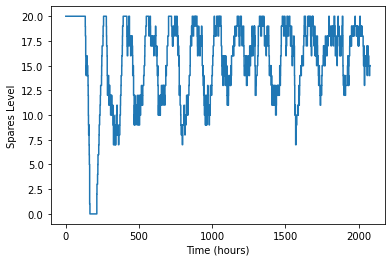

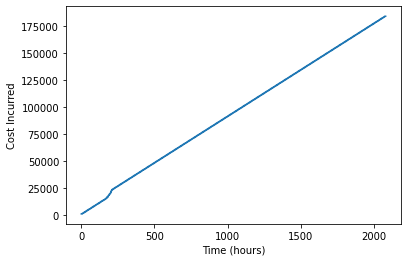

In [20]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

def factory_run(env, repairers, spares):
    global cost
    
    cost = 0.0
    
    for i in range(50):
        env.process(operate_machine(env, repairers, spares))
    
    while True:
        cost += 3.75*8*repairers.capacity + 30*spares.capacity
        yield env.timeout(8.0)


def operate_machine(env, repairers, spares):
    global cost
    
    while True:
        yield env.timeout(generate_time_to_failure())
        t_broken = env.now
        print('{:.2f} machine broke'.format(t_broken))
        # launch repair process
        env.process(repair_machine(env, repairers, spares))
        yield spares.get(1)
        t_replaced = env.now
        print('{:.2f} machine replaced'.format(t_replaced))
        cost += 20*(t_replaced-t_broken)

def repair_machine(env, repairers, spares):
    with repairers.request() as request: # what is this??
        yield request
        yield env.timeout(generate_repair_time())
        yield spares.put(1)
        print('{:.2f} repair complete'.format(env.now))

def generate_time_to_failure():
    return np.random.uniform(132, 182)

def generate_repair_time():
    return np.random.uniform(4,10)

obs_time = []
obs_cost = []
obs_spares = []

def observe(env, spares):
    while True:
        obs_time.append(env.now)
        obs_cost.append(cost)
        obs_spares.append(spares.level)
        yield env.timeout(1.0)

np.random.seed(0)

env = simpy.Environment()

repairers = simpy.Resource(env, capacity=3)

spares = simpy.Container(env, init=20, capacity=20)

env.process(factory_run(env, repairers, spares))
env.process(observe(env, spares))

env.run(until=8*5*52)

plt.figure()
plt.step(obs_time, obs_spares, where='post')
plt.xlabel('Time (hours)')
plt.ylabel('Spares Level')

plt.figure()
plt.step(obs_time, obs_cost, where='post')
plt.xlabel('Time (hours)')
plt.ylabel('Cost Incurred')

print('total cost was {:.2f}'.format(obs_cost[-1]))

